# 時系列分析と状態空間モデルの基礎
- stan部分をpystanを用いて実装

2020/8/24 nakanakana12

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
import os
import pystan

# グラフ描画
from matplotlib import pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set("talk")

#ダウンロードしたファイルのインポート
TEMPLATE_DIR = "/content/drive/My Drive/"
DATA_DIR = TEMPLATE_DIR + "data/" #dataを入れたフォルダを記載

os.chdir(DATA_DIR)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Stanによるローカルレベルモデルの推定


In [3]:
num = 100
prev_mu =100
sw=1000
sv=5000

mu_list = []
mu_list.append(prev_mu)
y_list = []

#状態の作成
for i in range(num-1):
  mu = np.random.normal(prev_mu,np.sqrt(sw))
  mu_list.append(mu)
  prev_mu=mu

#観測値の作成
for i in range(num):
  y = np.random.normal(mu_list[i],np.sqrt(sv))
  y_list.append(y)

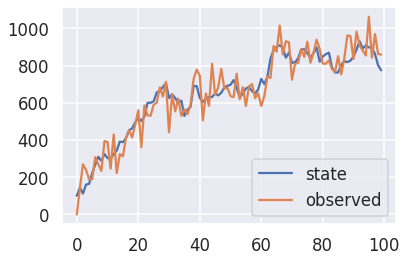

In [4]:
plt.plot(mu_list,label="state")
plt.plot(y_list,label="observed")
plt.legend()

In [5]:
#最初っからベクトルモデルで
model = """
data{
  int num; //サンプルサイズ
  real y[num]; //観測値
}

parameters{
  real prev_mu; //初期値
  real mu[num]; //状態量
  real<lower=0> sw; //状態の分散
  real<lower=0> sv; //観測の分散
}

model{
  mu[1] ~ normal(prev_mu,sqrt(sw)); //状態の初期値

  mu[2:num] ~ normal(mu[1:(num-1)],sqrt(sw)); //次の状態の推定

  y ~ normal(mu,sqrt(sv)); //観測状態の推定
}

"""

In [6]:
stm = pystan.StanModel(model_code=model) #コンパイル

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6c4f79f66c4ae78306e598977bb3409a NOW.


In [7]:
stan_data = {"y":y_list,"num":num}

iter_count = 5000
chain_count = 4
warmup_count = 2500
thin_count = 5

In [8]:
#パラメータ推定
fit = stm.sampling(data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count,
                  seed=0, algorithm="NUTS")

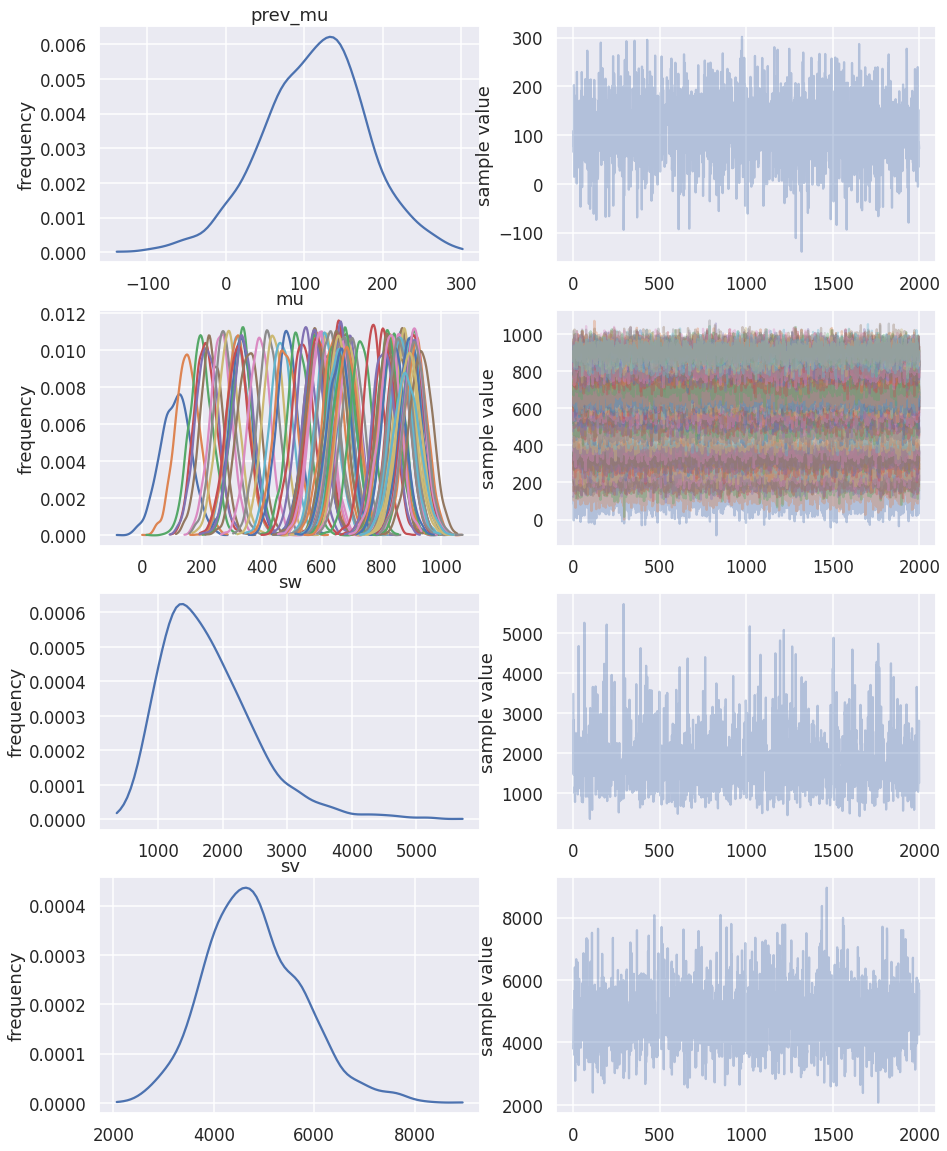

In [9]:
rcParams['figure.figsize'] = 15, 20
fig = fit.plot()


In [10]:
print(fit)

Inference for Stan model: anon_model_6c4f79f66c4ae78306e598977bb3409a.
4 chains, each with iter=5000; warmup=2500; thin=5; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
prev_mu 113.06    1.53   65.6 -19.93  70.57 116.49 156.04 239.79   1846    1.0
mu[1]   111.86    1.22  50.76   9.57  77.35 113.47 146.56 209.19   1726    1.0
mu[2]   151.45     0.9  40.31  74.33 124.37 151.03 179.13 229.23   2026    1.0
mu[3]   196.63    0.86  37.94 122.89 172.41 196.12 222.08 270.01   1960    1.0
mu[4]   212.65    0.82  37.42 141.87 186.69 211.54 237.83 288.13   2099    1.0
mu[5]   216.49    0.82  37.71  142.1  190.7 216.19 242.41 290.34   2128    1.0
mu[6]   231.68     0.8  37.02 159.16 206.59 230.27 257.13 302.58   2133    1.0
mu[7]    262.8    0.84  35.96 191.91 239.01 262.92 286.41 332.64   1816    1.0
mu[8]   273.66    0.81  36.97 201.21 249.15 272.59 298.11 346.41   2078    1.0
mu[9]   287.69    0.82

In [11]:
#EAP推定量
result = fit.extract()
result["sw"].mean() #過程誤差の平均

1778.233592101535

In [12]:
#平均，4分位点などの表示，
#desctibeが便利なため一度dataframeに移す
data = pd.DataFrame()
data["sw"] = result["sw"]
data["sw"].describe()

count    2000.000000
mean     1778.233592
std       731.699287
min       358.808636
25%      1254.991151
50%      1643.103269
75%      2172.008410
max      5716.632439
Name: sw, dtype: float64

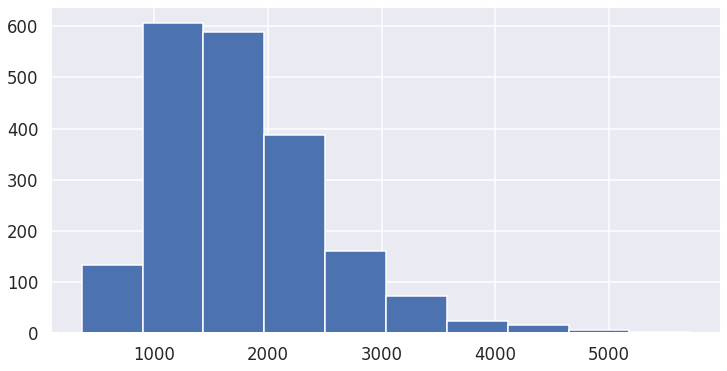

In [13]:
rcParams['figure.figsize'] = 12, 6
_=plt.hist(data["sw"])

(array([  1.,  21.,  76., 245., 474., 552., 432., 153.,  41.,   5.]),
 array([-84.35245807, -47.33376149, -10.31506492,  26.70363166,
         63.72232823, 100.7410248 , 137.75972138, 174.77841795,
        211.79711452, 248.8158111 , 285.83450767]),
 <a list of 10 Patch objects>)

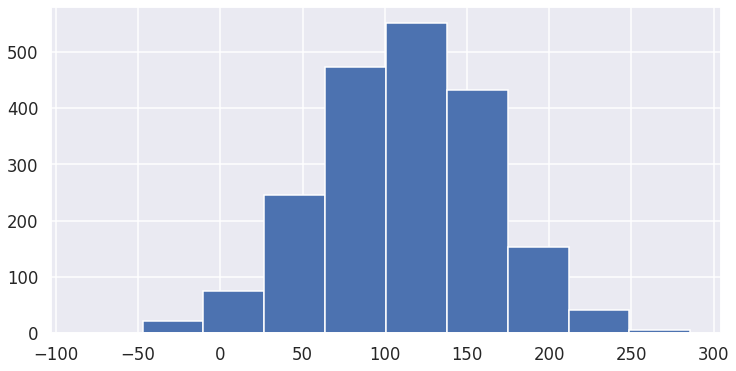

In [14]:
#1個目の状態の確率分布を取得
data["mu0"] = result["mu"][:,0]
plt.hist(data["mu0"])

In [15]:
#状態すべてをデータフレームに格納

data=pd.DataFrame()
for i in range(num):
  col="mu" + str(i)
  data[col] = result["mu"][:,i]


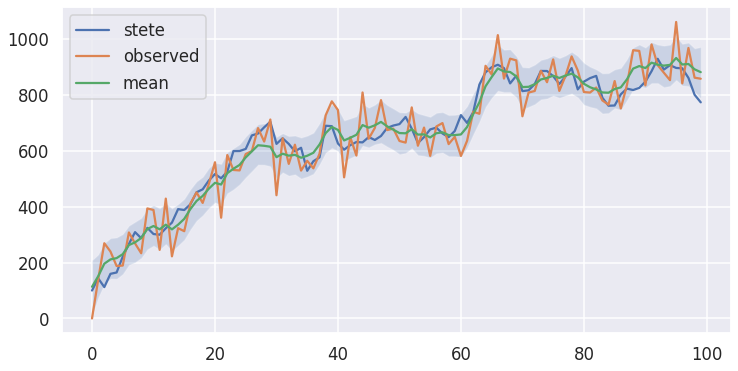

In [16]:
#状態の平均と95%信頼区間をプロット

plt.plot(mu_list,label="stete")
plt.plot(y_list,label="observed")

plt.plot(data.quantile(0.5).values,label="mean")
plt.fill_between(np.arange(num),
                 data.quantile(0.025).values,data.quantile(0.975).values,
                 alpha=0.2)

plt.legend()

## 応用:複雑な観察方程式を持つモデル

In [ ]:
df = pd.read_csv("data/6-5-logistic-growth-data.csv")
print(df.shape)
df.head()


(50, 2)


,time,y
0,1961,18
1,1962,17
2,1963,14
3,1964,43
4,1965,57


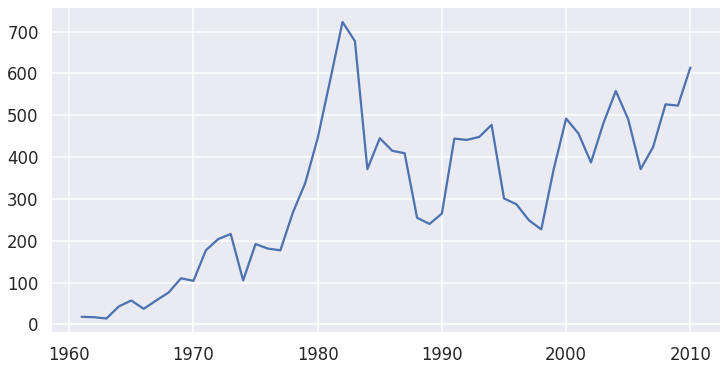

In [ ]:
plt.plot(df.time,df.y)

In [ ]:
model = """
data{
  int N; //サンプル数
  int y[N]; //観測値
}

parameters{
  real<lower=0> r; //内的自然増加率
  real<lower=0> K; //環境収容力
  real mu_zero; //初期状態
  real mu[N]; //状態量
  real <lower=0> s_w; //状態の分散
}

transformed parameters{
  real<lower=0> lambda[N]; //ポアソン分布の期待値

  for (i in 1:N){
    lambda[i] = exp(mu[i]);
  }
}


model{
  mu[1] ~ normal(mu_zero,sqrt(s_w)); //初期状態の推定

  for (i in 2:N){
    mu[i] ~ normal(mu[i-1] + r*mu[i-1] * (1-mu[i-1]/K),sqrt(s_w));
  }

  for (i in 1:N){
    y[i] ~ poisson(lambda[i]);
  }

  //弱情報事前分布
  K ~ normal(7,3);
}

// 過程誤差がない場合の期待値の変化
generated quantities{
  real mu_smooth[N]; 
  real lambda_smooth[N];

  mu_smooth[1] = mu_zero;

  for (i in 2:N){
    mu_smooth[i] = mu_smooth[i-1] + r*mu_smooth[i-1] * (1-mu_smooth[i-1]/K);
  }

  for (i in 1:N){
    lambda_smooth[i] = exp(mu_smooth[i]);
  }
}

"""

In [ ]:
stm = pystan.StanModel(model_code=model) #コンパイル

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce1133bfa5d66fc80744c1eeba2a9a5f NOW.


In [ ]:
stan_data = {"y":df.y.values,"N":len(df)}

iter_count = 5000
chain_count = 4
warmup_count = 100
thin_count = 5

In [ ]:
#パラメータ推定
fit = stm.sampling(data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count,
                  seed=0, algorithm="NUTS")

In [ ]:
result = fit.extract()
data = pd.DataFrame()
data["r"] = result["r"]
data["K"] = result["K"]
data["population"] = np.exp(result["K"]) #個体数
data.describe().T

,count,mean,std,min,25%,50%,75%,max
r,3920.0,0.166118,0.063457,0.000284,0.125209,0.169158,0.209108,0.391810
K,3920.0,6.245707,0.691167,3.039150,5.925472,6.103380,6.329322,13.209847
population,3920.0,1631.698959,16888.502012,20.887471,374.455064,447.367453,560.776524,545712.431921


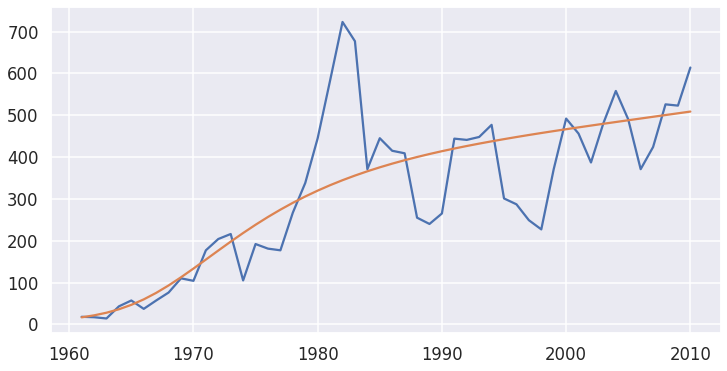

In [ ]:
#過程誤差がないと仮定したときの個体数をプロット

#状態すべてをデータフレームに格納
data2=pd.DataFrame()
for i in range(len(df)):
  col="lambda_smooth" + str(i)
  data2[col] = result["lambda_smooth"][:,i]

plt.plot(df.time,df.y)
plt.plot(df.time,data2.describe().T["mean"])